# Python и статистика

Проект №7 - введение в проблематику A/B-тестов, применение бутстрапа.

# Введение

## Загрузка библиотек

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm, mannwhitneyu, shapiro, bartlett

import pingouin as pg

from tqdm.auto import tqdm

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

## Загрузка данных

In [2]:
df = pd.read_csv('./data/hw_bootstrap.csv', sep = ';', index_col = 0)

In [3]:
df

,value,experimentVariant
1,"10,3804953740268",Control
2,"9,54686666784264",Control
3,"11,0882146509904",Control
4,"10,1472740570122",Control
5,"9,78980767524929",Control
...,...,...
996,1000,Treatment
997,1200,Treatment
998,1500,Treatment
999,2000,Treatment


In [4]:
df['value'] = df['value'].str.replace(',', '.').astype(float)

In [5]:
df.dtypes

value                float64
experimentVariant     object
dtype: object

## Подготовительная работа

In [6]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95, # уровень значимости
    visualise = True # нужно ли выводить гистограмму для полученных данных
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
#     Визуализация
    if visualise :
        plt.hist(pd_boot_data[0], bins = 50)
    
        plt.style.use('ggplot')
        plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
        plt.xlabel('boot_data')
        plt.ylabel('frequency')
        plt.title("Histogram of boot_data")
        plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

In [7]:
control_data = df[df['experimentVariant'] == 'Control']['value']
treatment_data = df[df['experimentVariant'] == 'Treatment']['value']

# Сравнение групп бутстрапом

## Вариант 1

Применим бутстрап (с ```np.mean```) и критерий Манна-Уитни, а потом сравним ```p-value```.

  0%|          | 0/1000 [00:00<?, ?it/s]

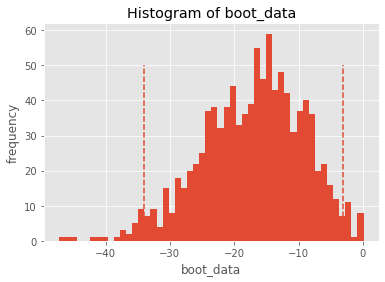

In [8]:
booted_data = get_bootstrap(control_data, treatment_data)

In [9]:
booted_data['p_value']

0.029333827805737938

In [10]:
booted_data['ci']

,0
0.025,-34.018957
0.975,-3.039036


Проверка полученных данных на нормальность:

In [11]:
shapiro(booted_data['boot_data'])

ShapiroResult(statistic=0.9883827567100525, pvalue=4.071560510965355e-07)

Уровень значимости намного меньше единицы, даже при граничном значении p = 0.05/10 мы можем отвергнуть нулевую гипотезу, имея малый шанс ошибиться. Можно (и нужно) применять критерий Манна-Уитни.

Если прогнать функцию для разных значений количества итераций ```boot_it``` (сколько раз мы проводили взятие новой, повторной выборки с возвращением, то для ```p_value``` мы получим (с округлением до третьего знака):

In [12]:
results = []
for N in [50, 100, 200, 500, 1000, 2000, 5000] :
    data = get_bootstrap(control_data, treatment_data, boot_it = N, visualise = False)
    results.append({'N': N,
                    'p_value': round(data['p_value'], 3)
                   }
                  )
    
pd.DataFrame(results)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

,N,p_value
0,50,0.068
1,100,0.045
2,200,0.049
3,500,0.045
4,1000,0.035
5,2000,0.037
6,5000,0.036


Как видим, увеличение количества итераций выше 1000 не даёт заметного изменения результатов. [Как известно](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)#cite_ref-22), приемлемый результат (в оценке ошибок, допущенных при использовании этого метода) можно (не всегда!) получить уже при 100 и даже 50 итерациях. Можно увидеть, что уже при 200 итерациях полученное значение ```p-value``` отличается от значений при N &geq; 1000 не более чем на 0.005.

### Проверка при помощи критерия Манна-Уитни

In [13]:
mannwhitneyu(control_data, treatment_data)

MannwhitneyuResult(statistic=124189.5, pvalue=0.8592148582485579)

Результаты сильно отличаются. При использовании бутстрапа мы получили величину ```p-value```, позволяющую отклонить нулевую гипотезу, тогдка как используя критерий Манна-Уитни для сравнения двух наборов данных, мы получили значение, близкое к единице. Отметим, что критерий Манна-Уитни проверяет нулевую гипотезу о равенстве распределений.

## Вариант 2

Применим бутстрап (с ```np.median```) и критерий Манна-Уитни, а потом сравним ```p-value```.

  0%|          | 0/1000 [00:00<?, ?it/s]

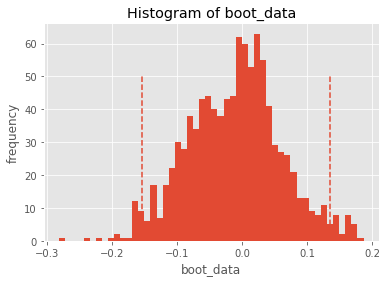

In [14]:
booted_data_2 = get_bootstrap(control_data, treatment_data, statistic = np.median)

In [15]:
booted_data_2['p_value']

0.8741446380395514

Если опять вычислять ```p-value``` при разном количестве итераций, то получим:

In [16]:
results_2 = []
for N in [50, 100, 200, 500, 1000, 2000, 5000] :
    data = get_bootstrap(control_data,
                         treatment_data,
                         boot_it = N,
                         statistic = np.median,
                         visualise = False)
    results_2.append({'N': N,
                      'p_value': round(data['p_value'], 3)
                     }
                    )
    
pd.DataFrame(results_2)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

,N,p_value
0,50,0.891
1,100,0.762
2,200,0.858
3,500,0.818
4,1000,0.898
5,2000,0.866
6,5000,0.891


Как видим, результаты для бутстрапа с ```np.median``` и сравнения с помощью критерия Манна-Уитни практически совпадают.

Более того, для получения результата, не отличающегося от результатов при большом (от 1000) количестве итераций, можно применять 50 итераций.

# Дописследование

Проверим контрольную и тестовую группу на нормальность.

#### Контрольная группа

In [17]:
shapiro(control_data)

ShapiroResult(statistic=0.9959248900413513, pvalue=0.22416365146636963)

<AxesSubplot:xlabel='value', ylabel='Count'>

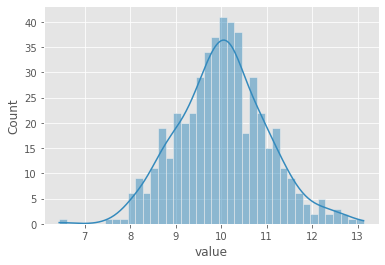

In [18]:
sns.histplot(control_data, kde = True, bins = 40)

#### Экспериментальные данные 

In [19]:
shapiro(treatment_data)

ShapiroResult(statistic=0.07038933038711548, pvalue=1.0930128021733573e-43)

<AxesSubplot:xlabel='value', ylabel='Count'>

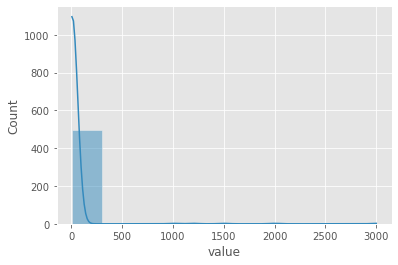

In [20]:
sns.histplot(treatment_data, kde = True, bins = 10)

Как видно, распределение экспериментальных данных полностью отличается от нормального.

Проверка данных, полученных бутстрапом по медиане (вторым способом), на нормальность:

In [21]:
shapiro(booted_data_2['boot_data'])

ShapiroResult(statistic=0.9967246651649475, pvalue=0.036201704293489456)

Аналогично предыдущему случаю, данные не нормальны (если считать что граничное значение равно 0.05), но при этом вероятность ошибиться при таком допущении намного выше (если на самом деле нулевая гипотеза верна и данные распределены нормально). По результатам построения QQ-plot данные всё же можно считать нормальными, тем более что граничное значение 0.05 всё же являетс "усреднённым общепринятым" и может и должно меняться в зависимости от (условий) задачи.

<AxesSubplot:title={'center':'Q-Q Plot'}, xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

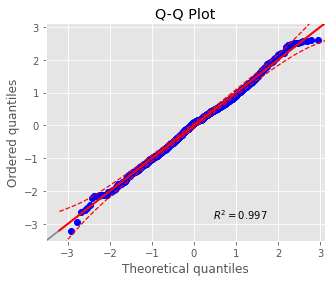

In [22]:
pg.qqplot(booted_data_2['boot_data'], dist = 'norm')

Проверим гомогенность дисперсий:

In [23]:
bartlett(booted_data_2['boot_data'], treatment_data.to_numpy())

BartlettResult(statistic=14064.896097166868, pvalue=0.0)

t-test применять нельзя

# Вывод

Подтверждается утверждение, что используемая мера центральной тенденции значительно влияет на результат бутстрапа. В данном случае свойства рассматриваемой группы лучше выражает медиана.

При использовании средного полученное "эмпирическое" бутстрап-распределение однозначно не является нормальным, а при использовании медианы -- близко к нормальному.

Для получения приемлемых результатов при использовании медианы достаточно всего 50 итераций бутстрапа, тогда как в первом случае -- от 500 до 1000.

## Итого
* Тестовая выборка имеет большие выбросы, что сильно искажает нам среднее значение
* Применяя бутстрап с оценкой среднего, мы могли бы отклонить нулевую гипотезу о равенстве средних и сделать вывод, что тестовая и контрольная выборка имеют различия
* Однако, тот же бутстрап, но уже по медиане не дает нам отклонить нулевую гипотезу, так как **p-value** сильно больше 0.05, т.к. здесь проверяется другая гипотеза
* U-критерий Манна-Уитни в обоих случаях показал высокую вероятность того, что распределения в выборках одинаковы. Однако данный критерий весьма чувствителен к дисбалансу между выборками, который оказывает сильное влияние на мощность критерия – чем сильнее дисбаланс, тем реже критерий будет обнаруживать реальную разницу (эффект) https://stats.stackexchange.com/questions/40342/mann-whitney-u-test-with-unequal-sample-sizes